In [16]:
# Set up
%pylab inline
# Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn.apionly as sns
#
REGDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Lung/QuadraticReg/"
regress = pd.read_csv(os.path.join(REGDIR, "quadratic_reg_out.table"), sep="\t")
permuted = pd.read_csv(os.path.join(REGDIR,"quadratic_reg_out_perm.table"), sep="\t")

def ExtractData(gene, chrom, start, tissue):
    """By MG"""
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def PlotESTR(gene, tissue, chrom, start, COLORS):
    strgt = pd.read_csv("str_genotypes_alleles.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    strgt['allele1'] = strgt['str'].apply(lambda x: x.split(',')[0])
    strgt['allele2'] = strgt['str'].apply(lambda x: x.split(',')[1])
    strgt['HOM'] = np.where(strgt['allele1'] == strgt['allele2'],1,0)
    strgt['str'] = strgt['allele1'].astype(int)+strgt['allele2'].astype(int)
    print(strgt.shape)
    strgt = strgt.loc[strgt['HOM']==1].copy()
    print(strgt.shape)
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS)
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s \n "%(chrom, start, gene))
    plt.suptitle("");
    plt.show()
    #fig.savefig("%s_Quad_estr.pdf"%gene)

     
REGDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Lung/"


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
#Remove None values
regress = regress.loc[(regress["delta_aic[Lin-Quad]"]!='None')]
permuted = permuted.loc[permuted["delta_aic[Lin-Quad]"]!='None']
#Control for reasonable values of alpha and beta pvalues  && R-squares in the quad
regress = regress.loc[(regress['alpha.pval'].astype(float)<0.1)|(regress['beta.pval'].astype(float)<0.1)]
regress = regress.loc[(regress['quad_rsq'].astype(float)>0.2)]#|(regress['beta.pval'].astype(float)<0.05)]
regress["delta_aic[Lin-Quad]"] = regress["delta_aic[Lin-Quad]"].astype(float)
#--Just get matching data in permuted--
regress = regress.replace([np.inf], np.nan)
regress['ID'] = regress['gene']+regress['str.id']
permuted['ID'] = permuted['gene']+permuted['str.id']
permuted = permuted.loc[permuted['ID'].isin(list(regress['ID']))].copy()

355


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


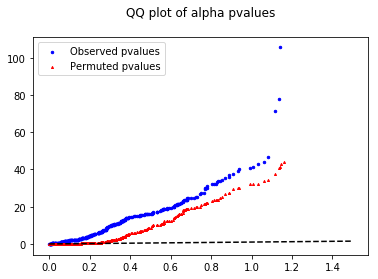

In [18]:
##QQplot for alpha
L=list(regress["delta_aic[Lin-Quad]"])
print(len(L))
#X = [x for x in range(len(L))]
unif = sorted(list(np.random.uniform(low=0, high=1, size=len(L))))
unif_log = [-1*np.log10(x) for x in unif]
pvals = sorted(list(regress["alpha.pval"].astype(float)))
pvals_log = [-1*np.log10(x) for x in pvals]
plt.scatter(unif_log, pvals_log, color='blue', label="Observed pvalues", s=6, marker='o')

pvalsp = sorted(list(permuted["alpha.pval"].astype(float)))
pvalsp_log = [-1*np.log10(x) for x in pvalsp]

plt.plot([0,1.5],[0,1.5], color="black", linestyle='--')
plt.scatter(unif_log, pvalsp_log, color='red', label="Permuted pvalues", s=4, marker='^')
plt.title("QQ plot of alpha pvalues\n")
plt.legend()
plt.show()

355


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


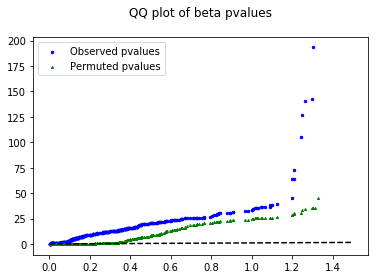

In [19]:
##QQplot for beta
L=list(regress["delta_aic[Lin-Quad]"])
print(len(L))
#X = [x for x in range(len(L))]
unif = sorted(list(np.random.uniform(low=0, high=1, size=len(L))))
unif_log = [-1*np.log10(x) for x in unif]
pvals = sorted(list(regress["beta.pval"].astype(float)))
pvals_log = [-1*np.log10(x) for x in pvals]
plt.scatter(unif_log, pvals_log, color='blue', label="Observed pvalues", s=6, marker='o')

pvalsp = sorted(list(permuted["beta.pval"].astype(float)))
pvalsp_log = [-1*np.log10(x) for x in pvalsp]

plt.plot([0,1.5],[0,1.5], color="black", linestyle='--')
plt.scatter(unif_log, pvalsp_log, color='green', label="Permuted pvalues", s=4, marker='^')
plt.title("QQ plot of beta pvalues\n")
plt.legend()
plt.show()

(231, 19)
(231, 19)


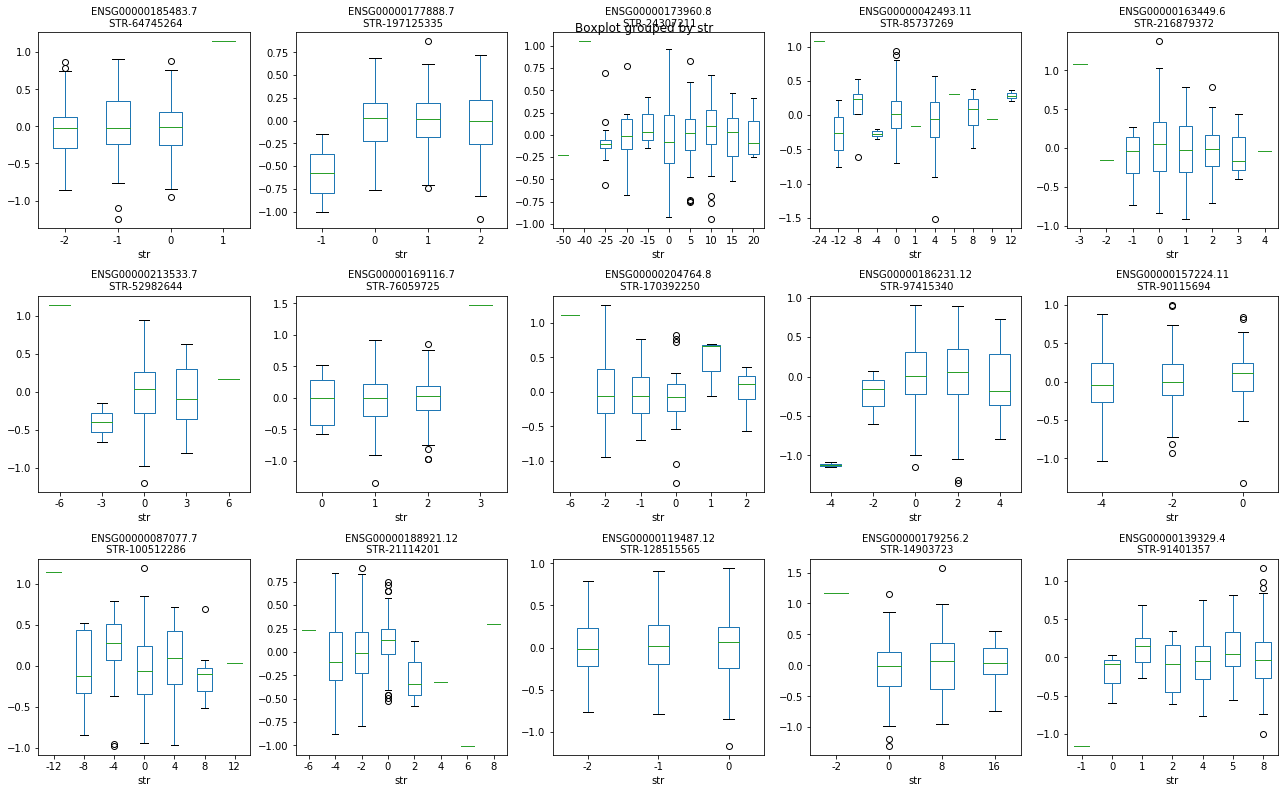

In [36]:
Goodexamples = regress.loc[(regress['linear.pval']>0.1)&(regress["delta_aic[Lin-Quad]"]>0)]
print (Goodexamples.shape)
Goodexamples1 = Goodexamples.loc[Goodexamples['delta_bic'].astype(float)>1]
print(Goodexamples1.shape)
squadestrs = Goodexamples.loc[Goodexamples['anova_pva'].astype(float)>0 ].head(15)

fig = plt.figure()
fig.set_size_inches((18, 18))
fignum = 1
for index, item in squadestrs.iterrows():
    chrom = item["chrom"].split('r')[1]
    gene = item["gene"]
    start = item['str.start']
    tissue = "Lung"
    alpha = float(item['alpha'])
    beta = float(item['beta']) 
    #print('Case'+str(fignum)+'  alpha=', alpha, ' beta=', beta, 'ANOVA pvalue=', item['anova_pva'])
    ExtractData(gene, chrom, start, tissue)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt['sample']=strgt['sample'].apply(lambda x: "-".join(x.split('-')[:2]))
#    strgt = strgt.loc[(strgt['str'] !=1) & (strgt['str'] !=-1)]
    data = pd.merge(strgt, expr)
    ax = fig.add_subplot(5, 5, fignum)
    data.boxplot(column="expr", by="str", ax=ax, grid=False);
    #ax.set_xlabel("Num. Repeats", size=8)
    #ax.set_ylabel("Gene Expression", size=8)
    ax.set_title(gene + "\n STR-"+str(start), size=10)
    fignum = fignum+1
#plt.xlabel('Number of Repeats')
#plt.ylabel('Gene Expression', rotation='vertical')
plt.tight_layout()
plt.show()
    
        

(231, 19)
(231, 19)
alpha= 1.20849634331  beta= -0.260792952473 ANOVA pvalue= 7.512909577072055e-88


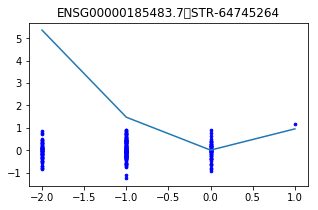

alpha= -0.150999737985  beta= -0.0949716746081 ANOVA pvalue= 7.306084791298619e-41


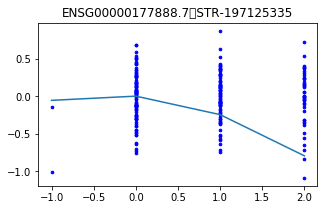

alpha= 0.00626053592625  beta= 0.000147903514433 ANOVA pvalue= 1.6859725019767666e-153


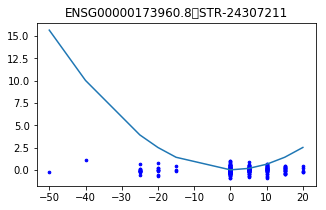

alpha= -0.00178332152085  beta= 0.000304151121592 ANOVA pvalue= 3.4205581177588284e-29


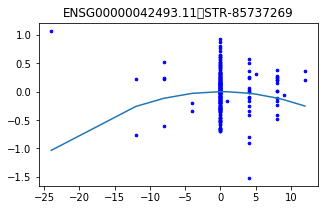

alpha= 0.00651376979903  beta= 0.0160449028047 ANOVA pvalue= 1.0959269006283619e-32


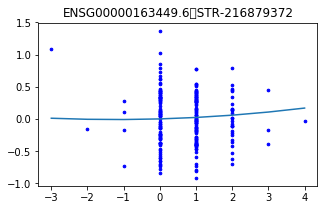

alpha= -0.00525078419057  beta= 0.0030648019783 ANOVA pvalue= 2.1338152199736544e-14


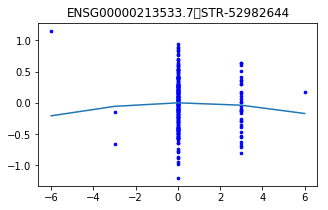

alpha= 0.07415409151060001  beta= 0.178194176836 ANOVA pvalue= 3.279665501690046e-122


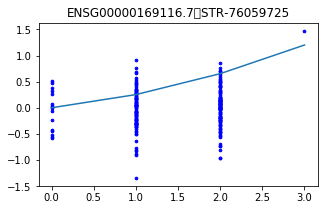

alpha= 0.0443115479927  beta= -0.0214207320134 ANOVA pvalue= 8.808967079179114e-79


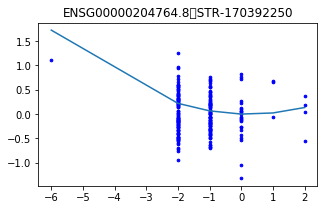

alpha= -0.0325800764881  beta= -0.0165064107109 ANOVA pvalue= 1.1570916650851147e-35


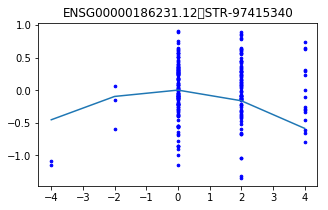

alpha= -0.586475097917  beta= 0.178498836911 ANOVA pvalue= 5.562532043640822e-197


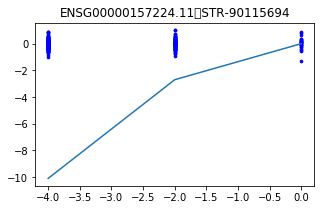

alpha= 0.0058787041166  beta= 0.000359173226631 ANOVA pvalue= 2.8670536837942057e-08


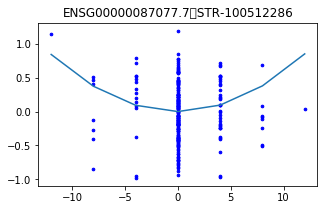

alpha= -0.023523519561  beta= 0.00359253160261 ANOVA pvalue= 6.82076066157945e-184


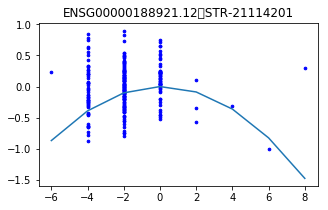

alpha= -0.606673429217  beta= 0.134216706128 ANOVA pvalue= 6.2410634667844e-135


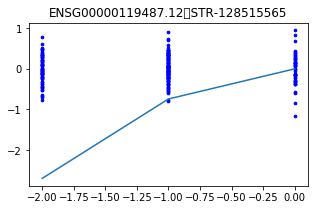

alpha= 0.104764281295  beta= 0.0919437311622 ANOVA pvalue= 4.6970845674719986e-192


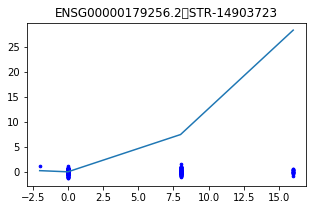

alpha= -0.00185091956917  beta= -0.0526452437477 ANOVA pvalue= 4.81424524e-315


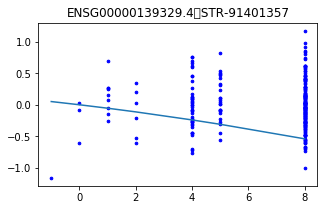

In [21]:
for index, item in squadestrs.iterrows():
    chrom = item["chrom"].split('r')[1]
    gene = item["gene"]
    start = item['str.start']
    tissue = "Lung"
    alpha = float(item['alpha'])
    beta = float(item['beta']) 
    print('alpha=', alpha, ' beta=', beta, 'ANOVA pvalue=', item['anova_pva'])
    ExtractData(gene, chrom, start, tissue)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt['sample']=strgt['sample'].apply(lambda x: "-".join(x.split('-')[:2]))
#    strgt = strgt.loc[(strgt['str'] !=1) & (strgt['str'] !=-1)]
    data = pd.merge(strgt, expr)
    plt.figure( figsize=(5,3))
    plt.scatter(data['str'], data['expr'], color='blue',marker='o', s=7)
    #fit a non-linear regression
    plt.title(gene+'\tSTR-'+str(start))
    x = sorted([float(i) for i in list(data['str'])])
    plt.plot(x,[alpha*i**2 + beta*i for i in x])
    plt.show()
    #break

In [38]:
for index, item in squadestrs.iterrows():
    chrom = item["chrom"].split('r')[1]
    gene = item["gene"]  
    start = item['str.start']
    tissue = "Lung"
    #genename = item['gene.name']
    #motif = item['motif']
    print('\nAlpha = ', item['alpha'], " Beta = ",item['beta'])
    ExtractData(gene, chrom, start, tissue)
    PlotESTR(gene, tissue, chrom, start, 'green')



,chrom,gene,str.id,str.start,alpha,alpha.se,alpha.pval,beta,beta.se,beta.pval,linear.beta,linear.beta.se,linear.pval,quad_rsq,lin_rsq,delta_aic[Lin-Quad],delta_bic,anova_pva,ID
